In [23]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as K
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import collections
import pandas as pd
from collections import Counter
from keras.applications.vgg16 import VGG16
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
train_path= 'train'
valid_path = 'valid'
test_path = 'test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10,shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)


Found 3833 images belonging to 4 classes.
Found 833 images belonging to 4 classes.
Found 892 images belonging to 4 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
print(imgs.shape)

(10, 224, 224, 3)


In [8]:
#plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

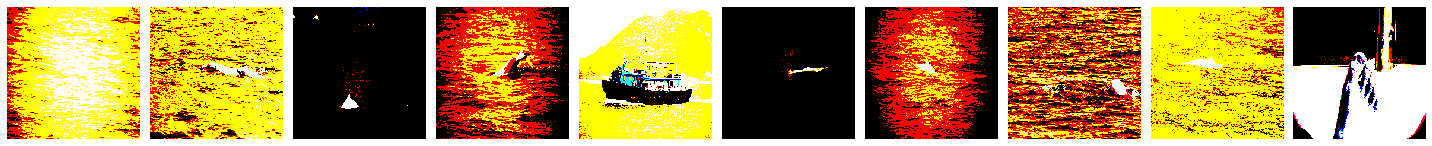

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Resnet model

In [11]:
# conv_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# for layer in conv_model.layers:
#     layer.trainable = False
# x = keras.layers.Flatten()(conv_model.output)
# x = keras.layers.Dense(500, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(300, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(100, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.5)(x)
# predictions = keras.layers.Dense(4, activation='softmax')(x)
# full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

# # adding regularization
# #regularizer = tf.keras.regularizers.l2(penalty)
# regularizer = tf.keras.regularizers.l2(0.1)

# for layer in full_model.layers:
#     for attr in ['kernel_regularizer']:
#         if hasattr(layer, attr):
#           setattr(layer, attr, regularizer)

# full_model.summary()

In [12]:
# counter = Counter(train_batches.classes)
# max_val = float(max(counter.values()))
# class_weights={class_id : max_val/num_images for class_id, num_images in counter.items()}
# full_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# history_1=full_model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

In [13]:
# pd.DataFrame(history_1.history).plot(figsize=(8,5))
# plt.grid(True)
# plt.show()

In [14]:
# predictions = full_model.predict(x=test_batches, verbose=0)
# cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
# cm_plot=['health','one','two','unused']
# plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [15]:
# print('0: Health , 1: One , 2: Two , 3: Unused')
# predictions = full_model.predict(x=test_batches, verbose=0)
# ytest= test_batches.classes
# ypredict = np.argmax(predictions,axis=-1)
# print(classification_report(ytest,ypredict))

In [16]:
# full_model.save('resnet2_one_unused_augmented_regularisation.h5')

# save predictions to csv

In [ ]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("resnet_2.csv")

# load second resnet model 

In [41]:
res_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

# for layer in res_model.layers[:143]:
for layer in res_model.layers:
    layer.trainable=False

for i,layer in enumerate (res_model.layers):
    print(i, layer.name, "-", layer.trainable)

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(500,activation='relu'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(300,activation='relu'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(100,activation='relu'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(4,activation='softmax'))

model.summary()

0 input_15 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv -

In [47]:
counter = Counter(train_batches.classes)
max_val = float(max(counter.values()))
class_weights={class_id : max_val/num_images for class_id, num_images in counter.items()}
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_1=model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=30,verbose=2)

Epoch 1/30
384/384 - 1004s - loss: 1.1123 - accuracy: 0.7777 - val_loss: 0.8003 - val_accuracy: 0.6827
Epoch 2/30
384/384 - 994s - loss: 1.1027 - accuracy: 0.7835 - val_loss: 0.8854 - val_accuracy: 0.6603
Epoch 3/30
384/384 - 991s - loss: 1.0814 - accuracy: 0.7861 - val_loss: 0.7975 - val_accuracy: 0.6805
Epoch 4/30
384/384 - 1002s - loss: 1.0139 - accuracy: 0.7981 - val_loss: 1.0787 - val_accuracy: 0.6211
Epoch 5/30
384/384 - 1002s - loss: 0.8564 - accuracy: 0.8064 - val_loss: 0.8888 - val_accuracy: 0.6760
Epoch 6/30
384/384 - 1003s - loss: 0.9152 - accuracy: 0.8142 - val_loss: 0.9039 - val_accuracy: 0.6682
Epoch 7/30
384/384 - 1004s - loss: 0.7688 - accuracy: 0.8401 - val_loss: 0.8005 - val_accuracy: 0.7007
Epoch 8/30
384/384 - 1002s - loss: 0.8670 - accuracy: 0.8223 - val_loss: 0.8574 - val_accuracy: 0.6928
Epoch 9/30
384/384 - 1003s - loss: 0.8395 - accuracy: 0.8341 - val_loss: 0.9341 - val_accuracy: 0.6693
Epoch 10/30
384/384 - 1003s - loss: 0.7618 - accuracy: 0.8442 - val_loss: 0

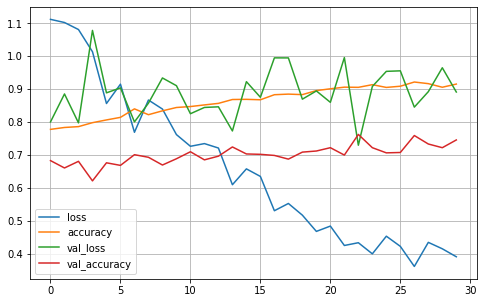

In [48]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[493   2  80   8]
 [  2  11  18   0]
 [ 41  10 122   0]
 [  0   0   0  46]]


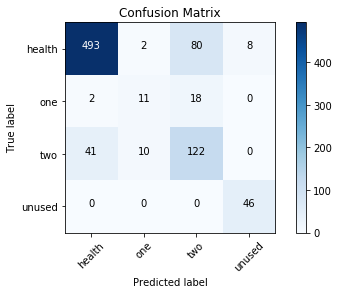

In [49]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [50]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       583
           1       0.48      0.35      0.41        31
           2       0.55      0.71      0.62       173
           3       0.85      1.00      0.92        46

    accuracy                           0.81       833
   macro avg       0.70      0.73      0.71       833
weighted avg       0.82      0.81      0.81       833



In [46]:
model.save('resnet_final.h5')